<a href="https://colab.research.google.com/github/khazzan/toolwearID/blob/main/Tool_Wear_Detection3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Import packages and libraries
!pip install -q tflite-model-maker
!sudo apt -y install libportaudio2
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools

!pip install -q opencv-python-headless==4.1.2.30
!pip uninstall -y tensorflow && pip install -q tensorflow==2.8.0
!git clone https://github.com/khazzan/toolwearID.git

import numpy as np
import os

from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 577.3/577.3 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.6/128.6 KB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.0/128.0 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 KB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
dataset_is_split = True
use_custom_dataset = True
if not use_custom_dataset:
  train_data, validation_data, test_data = object_detector.DataLoader.from_csv('wear_ml_use2.csv')
label_map = {1: 'flank_wear'} 

train_images_dir = 'toolwearID/split-dataset2/train/images'
train_annotations_dir = 'toolwearID/split-dataset2/train/annotations'
val_images_dir = 'toolwearID/split-dataset2/validation/images'
val_annotations_dir = 'toolwearID/split-dataset2/validation/annotations'
test_images_dir = 'toolwearID/split-dataset2/test/images'
test_annotations_dir = 'toolwearID/split-dataset2/test/annotations'

train_data = object_detector.DataLoader.from_pascal_voc(
        train_images_dir, train_annotations_dir, label_map=label_map)
validation_data = object_detector.DataLoader.from_pascal_voc(
        val_images_dir, val_annotations_dir, label_map=label_map)
test_data = object_detector.DataLoader.from_pascal_voc(
        test_images_dir, test_annotations_dir, label_map=label_map)

In [3]:
import random
images_path = test_images_dir if dataset_is_split else os.path.join(test_dir, "images")
filenames = os.listdir(os.path.join(images_path))
random_index = random.randint(0, len(filenames) -1)
!python3 -m pip install --extra-index-url https://google-coral.github.io/py-repo/ pycoral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://google-coral.github.io/py-repo/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 KB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 35.1 MB/s eta 0:00:00


In [4]:
#@title Default title text
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont

!python3 -m pip install tflite-runtime
!pip install tflite-support
import tflite_runtime.interpreter as tflite 


from pycoral.adapters import common
from pycoral.adapters import detect
from pycoral.utils.dataset import read_label_file

def draw_objects(draw, objs, scale_factor, labels):
  """Draws the bounding box and label for each object."""
  COLORS = np.random.randint(0, 255, size = (len(labels), 3), dtype = np.uint8)
  for obj in objs:
    bbox = obj.bbox
    color = tuple(int(c) for c in COLORS[obj.id])
    draw.rectangle([(bbox.xmin * scale_factor, bbox.ymin * scale_factor),
                    (bbox.xmax * scale_factor, bbox.ymax * scale_factor)],
                   outline = color, width = 3)
    font = ImageFont.truetype("LiberationSans-Regular.ttf", size = 15)
    draw.text((bbox.xmin * scale_factor + 4, bbox.ymin * scale_factor + 4),
              '%s\n%.2f' % (labels.get(obj.id, obj.id), obj.score),
              fill = color, font = font)

# Load the TF Lite model

LABELS_FILENAME = 'toolwearID/tf-lite_model2/wear-labels2.txt'
TFLITE_FILENAME = 'toolwearID/tf-lite_model2/efficientdet-lite-wear2.tflite'

labels = read_label_file(LABELS_FILENAME)
interpreter = tflite.Interpreter(TFLITE_FILENAME)
interpreter.allocate_tensors()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


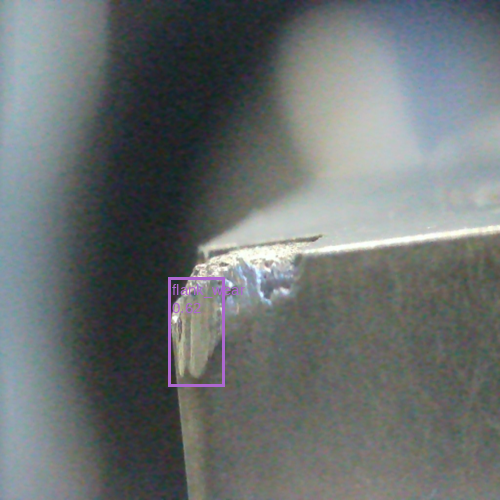

In [5]:
INPUT_IMAGE = os.path.join(images_path, filenames[24])
image = Image.open(INPUT_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold = 0.4, image_scale = scale)

# Resize again to a reasonable size for display
display_width = 500
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
if (objs != 0):
  draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
else:
  image = image
image

In [6]:
print(objs)
ratio = 0.00771 # 441px = 3.341mm
if (len(objs) == 0):
  wear_edge = 0
  vb_max = wear_edge
else:
  for x in range(len(objs)):
    wear_edge = "{:.2f}".format(((objs[x][2][2]) - (objs[x][2][0])) * ratio)
    vb_max = "{:.2f}".format(((objs[x][2][3]) - (objs[x][2][1])) * ratio)
    print("wear_edge_" + str(x) + ": " + str(wear_edge) + " mm")
    print("vb_max_" + str(x) + ": " +str(vb_max) + " mm")

# [rows, columns]
# crop = img[50:180, 100:300] 

[Object(id=0, score=0.625, bbox=BBox(xmin=345, ymin=569, xmax=459, ymax=791))]
wear_edge_0: 0.88 mm
vb_max_0: 1.71 mm


### Insitu images

In [7]:
insitu_images_dir = 'toolwearID/insitu-dataset'

insitu_filenames = os.listdir(os.path.join(insitu_images_dir))
random_index = random.randint(0, len(insitu_filenames) -1)


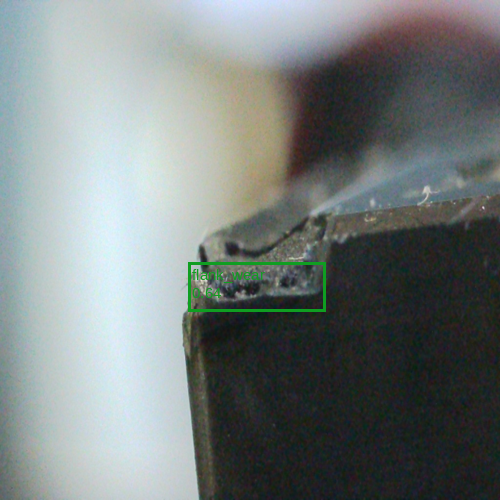

In [8]:
TESTING_IMAGE = os.path.join(insitu_images_dir, insitu_filenames[112])
image = Image.open(TESTING_IMAGE)
_, scale = common.set_resized_input(
    interpreter, image.size, lambda size: image.resize(size, Image.ANTIALIAS))

# Run inference
interpreter.invoke()
objs = detect.get_objects(interpreter, score_threshold = 0.4, image_scale = scale)

# Resize again to a reasonable size for display
display_width = 500
scale_factor = display_width / image.width
height_ratio = image.height / image.width
image = image.resize((display_width, int(display_width * height_ratio)))
if (objs != 0):
  draw_objects(ImageDraw.Draw(image), objs, scale_factor, labels)
else:
  image = image
image

In [9]:
print(objs)
ratio = 0.00771 # 441px = 3.341mm
if (len(objs) == 0):
  wear_edge = 0
  vb_max = wear_edge
else:
  for x in range(len(objs)):
    wear_edge = "{:.2f}".format(((objs[x][2][2]) - (objs[x][2][0])) * ratio)
    vb_max = "{:.2f}".format(((objs[x][2][3]) - (objs[x][2][1])) * ratio)
    print("wear_edge_" + str(x) + ": " + str(wear_edge) + " mm")
    print("vb_max_" + str(x) + ": " +str(vb_max) + " mm")

[Object(id=0, score=0.63671875, bbox=BBox(xmin=387, ymin=538, xmax=666, ymax=638))]
wear_edge_0: 2.15 mm
vb_max_0: 0.77 mm


In [12]:
#Once the wear measurement has retrieve use that to inform the decision
#Function for tool reconditioning method should use the wear_edge and vb_max values
#if 2 or more regions are there sum the max value of each
# input tool shape and if chip breaker
#Parameters list for each in order = [%, kHz, mm/s, mm]

plg = [[85, 100, 750, 0.01], [100, 150, 50, 0.05]]
plm = [[70, 70, 1000, 0.01], [100, 100, 50, 0.01]]
plr = [85, 70, 1000, 0.01]
pln = [100, 100, 20, 0.005]
plp = [100, 200, 10, 0.005]

def reconSelection(a, b, c):
  #a relates to wear_edge
  #b realtes to vb_max
  a = float(a)
  b = float(b)
  if ((a < 0.3) and (b < 0.2)):
    print("no need to recondition")
  elif (((b >= 0.2) and (b < 0.4)) and (a < 0.5)) or ((b < 0.2) and ((a >= 0.3) and (a < 1.5))):
    print("plg option chosen")
  elif (((b >= 0.2) and (b < 0.6)) and (a > 0.5)):
    print("plm option chosen")
  elif ((b >= 0.6) and (b < 1.25)) or (((b >= 0.4) and (b < 0.6)) and (a < 0.5)):
    print("plr option chosen")


  #d is if there is a chip breaker
  if (c == 1):
    print("need additional step pln + add extra lasr code to compensate")
  else:
    print("keep initial code")
  return  


reconSelection(wear_edge, vb_max, 0)

plr option chosen
keep initial code
